In [1]:
using QuantumOptics
using Statistics
using PyPlot
using Random
using JLD2
using CollectiveSpins

In [2]:
function prepare_theta_state(N_ES)
    return shuffle(vcat(zeros(Int, N_ES), ones(Int, N-N_ES)*pi))
end

""" Renormalize list of spins for independent case. Maps <σz> to go from [-1, 1] to [-1, 2N_ES/N - 1] """
function renorm_spin(list_spins, N_ES, N)
    return (list_spins.+1) .* (N_ES/N) .-1
end

""" Prepare the initial state of the system 
with a phase correlation imposed between the atoms
because the laser arrive on the lattice with an angle θl """
function prepare_phi_IS(θl, λl, theta_array)
    phi_array = zeros(N)
    for i = 1:N
        phi_array[i] = 2pi * sqrt(sum((system.spins[i].position .* [cos(θl), sin(θl), 0]) .^ 2))
    end
    return phi_array
end

prepare_phi_IS

### Define the system

In [3]:
# Define geometry of system
Nx,Ny,Nz = [5,5,1] #5x5x3=75 sites takes about 6 seconds to calculate on my laptop (first time is slower ofcourse)
N = Nx*Ny*Nz
d_xy, d_z = 266., 532.
λ = 1299.
θl = 30*pi/180

theta_init = 0 # Only interesting case to distinguish Elec/Elec+Mgt
phi_init = 0

# Integration time
Tstep = 1e-3
Tend = 1
T= [0:Tstep:Tend;];

In [4]:
a,b,c = [d_xy,d_xy,d_z]/λ
geo = CollectiveSpins.geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
e = [0,0,1]   # Quantization axis
system = CollectiveSpins.SpinCollection(geo, e, gammas=1.);

### Computations

In [5]:
repetition = 10; # Nbr of repetition per initial excited states

In [6]:
Mean_σz_array = []
Std_σz_array = []
Diff_mean_σz_array = []
Std_diff_σz_array = []
Diff_mean_σz_array_max = []
Std_diff_σz_array_max = []

for N_ES in 1:2:N
    println(string(N_ES)*"/"*string(N))

    σz_rep = []

    for j = 1:repetition
        # Initial state
        Ψ0 = CollectiveSpins.mpc.blochstate(zeros(N), prepare_theta_state(N_ES))
        ρt = CollectiveSpins.mpc.timeevolution(T, system, Ψ0, dt=Tstep)[2]
        push!(σz_rep, [(-1 *(mean(CollectiveSpins.mpc.sz(ρ)) +1)/2 -6) for ρ in ρt])
    end

    push!(Mean_σz_array, mean(σz_rep))
    push!(Std_σz_array, std(σz_rep))
    push!(Diff_mean_σz_array, (diff(Mean_σz_array[end])./Tstep))
    push!(Std_diff_σz_array, std([(diff(σz)/Tstep) for σz in σz_rep]))
    push!(Diff_mean_σz_array_max, maximum(diff(Mean_σz_array[end])./Tstep))
    push!(Std_diff_σz_array_max, std([maximum(diff(σz)/Tstep) for σz in σz_rep]))
end

1/25
3/25
5/25
7/25
9/25
11/25
13/25
15/25
17/25
19/25
21/25
23/25
25/25


In [7]:
# Independent case
phi, theta = 0., 0.
Ψ0_ind = CollectiveSpins.independent.blochstate(phi, theta, N)
geo = CollectiveSpins.geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
system = CollectiveSpins.SpinCollection(geo, e, gammas=1.)
tout, ρt_ind = CollectiveSpins.independent.timeevolution(T, system, Ψ0_ind, dt=Tstep)
mean_σz_ind = [mean(CollectiveSpins.independent.sz(ρ)) for ρ in ρt_ind]

Mean_σz_ind_array = []
Diff_mean_σz_ind_array = []

for N_ES in 1:2:N
    push!(Mean_σz_ind_array, (-1 .*(renorm_spin(mean_σz_ind, N_ES, N) .+1) ./2) .-6)
    push!(Diff_mean_σz_ind_array, diff(Mean_σz_ind_array[end])/Tstep)
end

### Plot CS

In [8]:
close("all")
figure()
for i = 1:N÷2
    plot(Mean_σz_array[i], label=string(i))
    plot(Mean_σz_ind_array[i], linestyle="--", label=string(i))
end
legend()
pygui(false);
#pygui(true); show()

false

# Load QC

In [9]:
@load "NES_MaxSlope_QC_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(0, digits=1))_phi_$(0)_thetal_$(round(θl, digits=2)).jld2" var_FF_max_diff_mean_σz std_var_FF_max_diff_mean_σz sols;

In [10]:
for s in sols
    plot(diff(s)./Tstep)
end

In [11]:
mean_QC_sigmaz = []
counter = 1
σz_rep = []
for s in sols
    push!(σz_rep, s)
    if counter%repetition==0 && counter > 1
        push!(mean_QC_sigmaz, mean(σz_rep))
        σz_rep = []
    end
    counter +=1
end

In [12]:
close("all")
figure()

PyPlot.rc("font", size = 12)

colorz = String[]

for i = 1:3:13
    plt = plot(T[1:end-1], diff(mean_QC_sigmaz[i])./Tstep, label=L"N_{ES} = "*string((2*i-1)))
    push!(colorz, plt[1].get_color())
end

#= for i = 1:2:13
    plot(T[1:end-1], diff(mean_QC_sigmaz[i])./Tstep)
end
 =#

counter = 1
for i = 1:3:13
    plot(T[1:end-1], Diff_mean_σz_array[i], linestyle="-.", color=colorz[counter])
    counter += 1
end
counter = 1
for i = 1:3:13
    plot(T[1:end-1], diff(Mean_σz_ind_array[i])./Tstep, linestyle="--", color=colorz[counter])
    counter += 1
end

xlabel(L"t/\tau", fontsize=16)
ylabel(L"\langle\sigma_z\rangle", fontsize=16)
legend()
savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/Vary_NES_Decay_rateMGT.pdf", bbox_inches="tight")
pygui(false);
#pygui(true); show()

false

In [13]:
Std_diff_σz_array_max

13-element Vector{Any}:
 1.1589360157175735e-5
 2.6440981263693792e-5
 2.7353773150411864e-5
 3.979089446477071e-5
 4.920937333257559e-5
 5.2853829760104874e-5
 4.13093616463656e-5
 5.309211382120286e-5
 0.00237048457197717
 0.01133964675528715
 0.021483954197514858
 0.012520779647124057
 0.0

In [14]:
close("all")
figure()
plot([i/N for i = 1:2:N], var_FF_max_diff_mean_σz)
plot([i/N for i = 1:2:N], [maximum(Diff_mean_σz_array[i]) for i = 1:length(Diff_mean_σz_array)], linestyle="--")
errorbar([i/N for i = 1:2:N], Diff_mean_σz_array_max, yerr=Std_diff_σz_array_max, linestyle="-.")
pygui(false); 

### Plots

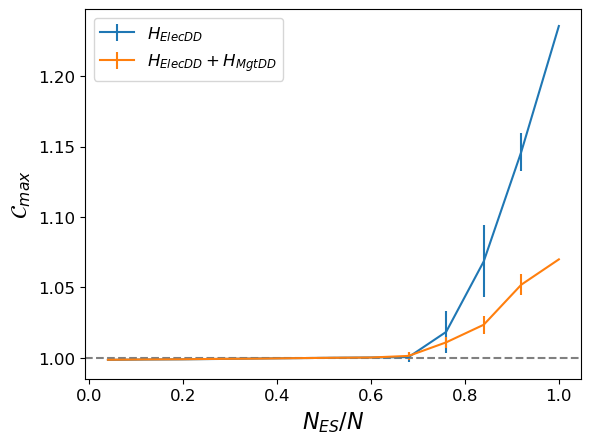

In [19]:
close("all")
figure()

PyPlot.rc("font", size = 12)

errorbar([i/N for i = 1:2:N], [Diff_mean_σz_array_max[i]/Diff_mean_σz_ind_array[i][1] for i = 1:length(Diff_mean_σz_array_max)], yerr=[Std_diff_σz_array_max[i]/Diff_mean_σz_ind_array[i][1] for i=1:length(Std_diff_σz_array_max)], label=L"H_{ElecDD}")
errorbar([i/N for i = 1:2:N], [var_FF_max_diff_mean_σz[i]/Diff_mean_σz_ind_array[i][1] for i=1:length(var_FF_max_diff_mean_σz)], yerr=[std_var_FF_max_diff_mean_σz[i]/Diff_mean_σz_ind_array[i][1] for i=1:length(std_var_FF_max_diff_mean_σz)], label=L"H_{ElecDD}+H_{MgtDD}")

xlabel(L"N_{ES}/N", fontsize=16)
ylabel(L"\mathcal{C}_{max}", fontsize=16)
#yscale("log")
axhline(1, linestyle="--", color="gray")
#axvline(0.5, linestyle="--", color="gray")
#title(L"Normalised initial slope of $<\sigma_z>$ as a function of "*"\n"*"the number of ES in the initial state")
legend()
savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/Max_slope(NES).pdf", bbox_inches="tight")

pygui(false); gcf()

#pygui(true); show()

In [16]:
# Save data
#= save_object("Mean_sigmaz_var_NES_rep.jld2", Diff_mean_σz_array)
save_object("Std_sigmaz_var_NES_rep.jld2", Std_diff_σz_array) =#

In [17]:
# Load data
Diff_mean_σz_array = load_object("Mean_sigmaz_var_NES_rep.jld2")
Std_diff_σz_array = load_object("Std_sigmaz_var_NES_rep.jld2");